In [1]:
%pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 11.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 11.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [3]:
images = np.load("data/images.npy")

In [4]:
images.shape

(2000, 28, 28)

In [5]:
# Normalise image data between 0 and 1
images = images/np.max(images)

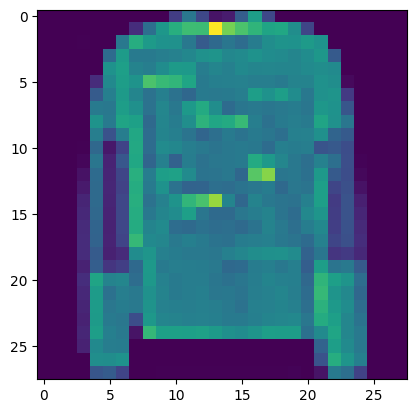

In [6]:
plt.imshow(images[700])

In [7]:
# flatten each image to a row vector
def flatten_images(images: list) -> list:
    flattened_images = []
    for image in images:
        flattened_images.append(image.flatten())
    return np.array(flattened_images)
flat_images = flatten_images(images)

<h3> Total Variance Captured </h3>

In [8]:
total_var_pca = np.zeros(9)
for i in range(1, 10):
    pca_i = PCA(n_components=i**2)
    pca_i.fit(flat_images)
    total_var_pca[i-1] = pca_i.explained_variance_ratio_.sum()

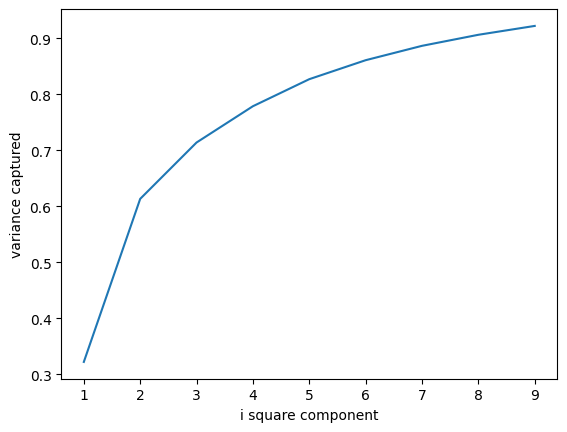

In [9]:
plt.ylabel("variance captured")
plt.xlabel("i square component")
plt.plot(np.arange(1, 10), total_var_pca)
plt.show()

In [10]:
# use PCA to achieve image reduction
pca = PCA(n_components=16, whiten=True)  # using 16 components, so we have 4x4 for each image
reduced_images = pca.fit_transform(flat_images)

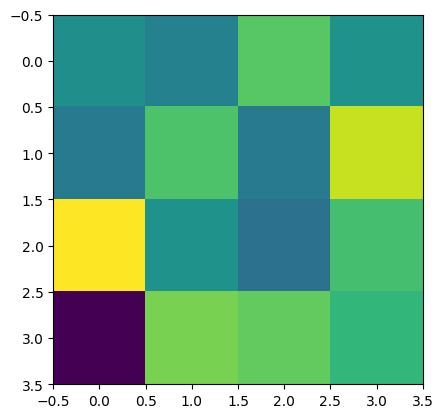

In [11]:
plt.imshow(reduced_images[10].reshape(4,4))

In [12]:
reduced_images[10]

array([-0.30856706, -0.66432543,  1.15536046, -0.22407948, -0.83931181,
        1.02554093, -0.82357407,  2.20864528,  2.73044089, -0.23183807,
       -1.05308752,  0.94088298, -3.34246575,  1.51844776,  1.27304963,
        0.67652107])

In [13]:
reduced_images.shape

(2000, 16)

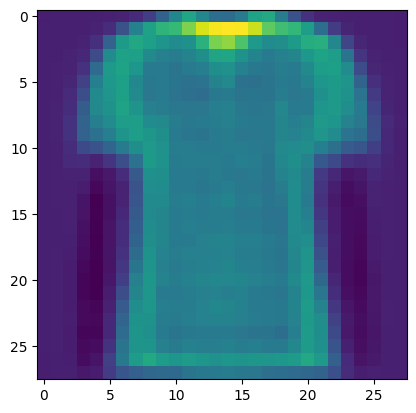

In [14]:
# map back from lower space to original space
plt.imshow(pca.inverse_transform(reduced_images).reshape(2000, 28, 28)[100])

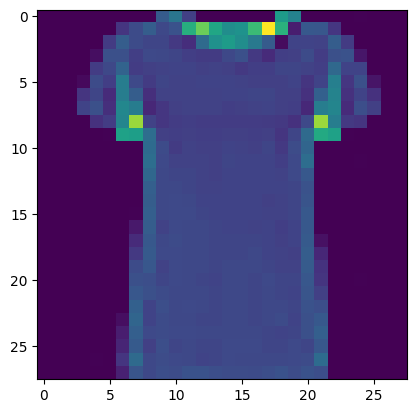

In [15]:
plt.imshow(images[100])

In [16]:
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import TwoLocal

In [100]:
TRAIN_DATA = []
TRAIN_LABELS = [int(x) for x in np.load('data/labels.npy')]

for image in reduced_images:
    scaler = MinMaxScaler()
    scaler.fit(image.reshape(-1,1))
    normalised = scaler.transform(image.reshape(-1,1))
    normlist = [float(x) for x in normalised]
    TRAIN_DATA.append([np.pi*n for n in normlist])
    
TRAIN_DATA = TRAIN_DATA[0:20]
TRAIN_LABELS = TRAIN_LABELS[0:20]

In [101]:
# Parametrize input data
qubit_num = 16
theta_list = ParameterVector('th', length=qubit_num)
qc = QuantumCircuit(qubit_num)
    
        
#for i in range(len(normalised)):
   # theta_list[i] = np.pi*float(normalised[i])
    

for i in range(len(theta_list)):
    qc.ry(theta_list[i], i)

#Set up PQC 
PQC = TwoLocal(qubit_num, ['rx', 'rz'], 'cz', reps=1)

TEST_CIRCUIT = qc.compose(PQC)
TEST_CIRCUIT.measure_all()
#TEST_CIRCUIT.decompose().draw()

In [102]:
def circuit_instance(data, variational):
    parameters = {}
    for i, p in enumerate(list(theta_list)):
        parameters[p] = data[i]
    for i, p in enumerate(PQC.ordered_parameters):
        parameters[p] = variational[i]
    
    #print('circuit instance')
    return TEST_CIRCUIT.assign_parameters(parameters)

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    #print('probabilities calculated')
    return probabilities

from qiskit import BasicAer, execute

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(i, variational) for i in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    print('circuits simulated')
    return classification

def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    print('cost function writen')
    return cost

circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen


circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102]
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105]
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108]
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111]
circuits simulated
cost functi

circuits simulated
cost function writen
circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180]
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183]
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 

circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237]
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240]
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function wr

circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273, 276, 279, 282, 285]
circuits simulated
cost function writen
circuits simulated
cost function writen
circuits simulated
cost function writen
[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 

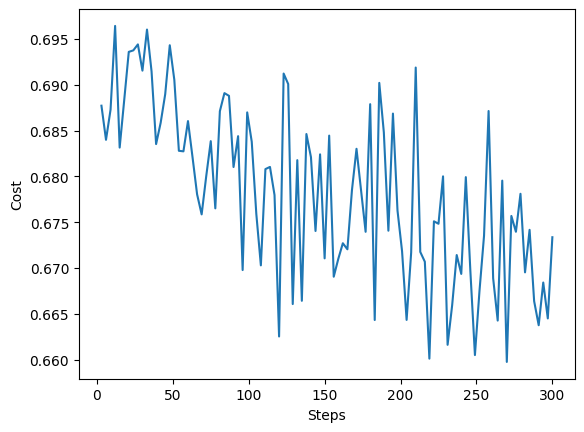

In [103]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
        print(self.evaluations)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

initial_point = np.random.random(PQC.num_parameters)

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
result = optimizer.minimize(objective_function, initial_point)

opt_var = result.x
opt_value = result.fun

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [109]:
import pickle

parameters = {}
for i, p in enumerate(PQC.ordered_parameters):
        parameters[p] = opt_var[i]
classifier = PQC.assign_parameters(parameters)
with open('part2.pickle', 'wb') as f:
    pickle.dump(classifier, f)

In [91]:
#re initialise test data 
TRAIN_LABELS = [int(x) for x in np.load('data/labels.npy')]

for image in reduced_images:
    scaler = MinMaxScaler()
    scaler.fit(image.reshape(-1,1))
    normalised = scaler.transform(image.reshape(-1,1))
    normlist = [float(x) for x in normalised]
    TRAIN_DATA.append([np.pi*n for n in normlist])

In [94]:
def test_classifier(data, labels, variational):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `data`
        list: Classifier's label predictions for each data point
    """
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions


TEST_DATA = TRAIN_DATA[1000:1100]
TEST_LABELS = TRAIN_LABELS[1000:1100]
accuracy, predictions = test_classifier(TEST_DATA, TEST_LABELS, opt_var)
accuracy

circuits simulated


0.57

In [26]:
def _encoding(images):
    encoded_images = []
    for image in images:
        qc = QuantumCircuit(16,16)
        # Normalise data in image (might have to save normalisation to inverse later)
        
        scaler = MinMaxScaler()
        scaler.fit(image.reshape(-1,1))
        normalised = scaler.transform(image.reshape(-1,1))
        
        for i in range(len(normalised)):
            qc.ry(np.pi*float(normalised[i]), i)
            
        qc.measure(np.arange(0,16,1),np.arange(0,16,1))
        encoded_images.append(qc)
    return encoded_images

In [27]:
encoded_images = _encoding(reduced_images)

In [28]:
encoded_images[10].draw()

┌────────────┐┌─┐                                             
 q_0: ┤ Ry(1.5674) ├┤M├─────────────────────────────────────────────
      ├────────────┤└╥┘┌─┐                                          
 q_1: ┤ Ry(1.3831) ├─╫─┤M├──────────────────────────────────────────
      ├────────────┤ ║ └╥┘┌─┐                                       
 q_2: ┤ Ry(2.3257) ├─╫──╫─┤M├───────────────────────────────────────
      ├────────────┤ ║  ║ └╥┘┌─┐                                    
 q_3: ┤ Ry(1.6111) ├─╫──╫──╫─┤M├────────────────────────────────────
      ├────────────┤ ║  ║  ║ └╥┘┌─┐                                 
 q_4: ┤ Ry(1.2925) ├─╫──╫──╫──╫─┤M├─────────────────────────────────
      ├────────────┤ ║  ║  ║  ║ └╥┘┌─┐                              
 q_5: ┤ Ry(2.2584) ├─╫──╫──╫──╫──╫─┤M├──────────────────────────────
      ├────────────┤ ║  ║  ║  ║  ║ └╥┘┌─┐                           
 q_6: ┤ Ry(1.3006) ├─╫──╫──╫──╫──╫──╫─┤M├───────────────────────────
      ├────────────┤ ║  ║  ║  ║  ║  ║ └╥┘┌─┐                        
 q_7: ┤ Ry(2.8712) ├─╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────
      └─┬───────┬──┘ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                     
 q_8: ──┤ Ry(π) ├────╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────
      ┌─┴───────┴──┐ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                  
 q_9: ┤ Ry(1.6074) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────
      ├────────────┤ ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐               
q_10: ┤ Ry(1.1827) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────
      ├────────────┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐            
q_11: ┤ Ry(2.2161) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────
      └─┬───────┬──┘ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐         
q_12: ──┤ Ry(0) ├────╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────
      ┌─┴───────┴──┐ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
q_13: ┤ Ry(2.5063) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────
      ├────────────┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
q_14: ┤ Ry(2.3753) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
      ├────────────┤ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_15: ┤ Ry(2.0544) ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
      └────────────┘ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
c: 16/═══════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                     0  1  2  3  4  5  6  7  8  9  10 11 12 13 14 15

<h3> simulating and plotting histogram </h3>

In [303]:
from qiskit.visualization import plot_histogram
from qiskit import Aer, transpile

In [304]:
len(encoded_images)

2000

In [363]:
#tmp_img.measure_all()
simulator = Aer.get_backend('aer_simulator')
#tmp_img = transpile(tmp_img, simulator)

shot_num = 10000

#index each qubit in the binary number
num = 16
decoded = []
for i in range(len(encoded_images)):
    amplist = np.zeros(16)
    tmp_img = encoded_images[i]
    result = simulator.run(tmp_img, shots=shot_num).result()
    counts = result.get_counts(tmp_img)
    keys = list(counts.keys())
    for k in range(len(keys) - 1):
            binlist = [int(d) for d in str(keys[k])]
            amplist = amplist + [x * counts[keys[k]]/shot_num for x in binlist]
    
    decoded.append(amplist)
#plot_histogram(counts, title='Bell-State counts')

In [364]:
decoded[10]

array([0.7452, 0.8537, 0.9024, 0.    , 0.8002, 0.3101, 0.5191, 0.9999,
       0.983 , 0.3652, 0.815 , 0.3643, 0.5307, 0.8461, 0.4139, 0.4913])

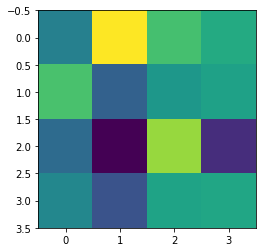

In [343]:
plt.imshow(reduced_images[700].reshape(4,4))

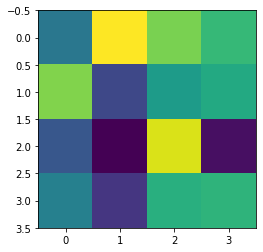

In [344]:
plt.imshow(np.rot90(amplist.reshape(4,4),2))

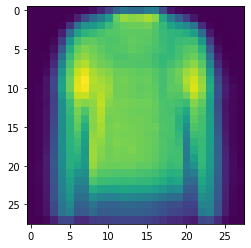

In [370]:
plt.imshow(pca.inverse_transform(decoded).reshape(2000, 28, 28)[100])

In [346]:
keys = list(counts.keys())
range(len(keys))
[int(d) for d in str(int(keys[4]))]
amplist = np.zeros(16-1)
[int(d) for d in str(keys[4])]

[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]

<h3> Decoding </h3>